In [1]:
%matplotlib inline


# True positive proportions in fMRI clusters using Notip

This script showcases the so-called Notip procedure [1], in
which the proportion of true discoveries in arbitrary clusters is estimated.
The clusters can be defined from the input image, i.e. in a circular way, as
the error control accounts for arbitrary cluster selection.


## Fetch dataset
We download a list of left vs right button press contrast maps from the so-called localizer dataset [2]. Note that we fetch individual t-maps that represent the
BOLD activity estimate divided by the uncertainty about this estimate.

In [11]:
from nilearn.datasets import fetch_localizer_contrasts
import numpy as np

n_subjects = 30
data = fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

Let's visualize the input data:

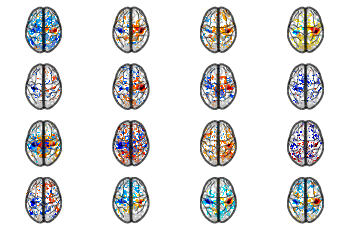

In [3]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain
fig, axes = plt.subplots(nrows=4, ncols=4)
for cidx, tmap in enumerate(data['tmaps'][:16]):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     axes=axes[int(cidx / 4), int(cidx % 4)],
                     plot_abs=False, annotate=False, display_mode='z')

To extract the information from these images, we need a masker:

In [4]:
from nilearn.maskers import NiftiMasker
smoothing_fwhm = 8.0
nifti_masker = NiftiMasker(smoothing_fwhm=smoothing_fwhm)

In [5]:
fmri_input = nifti_masker.fit_transform(data["cmaps"])

In [6]:
print(fmri_input.shape)

(30, 46482)


We have extracted the values of 46482 voxels from 30 images.

### Computing True Discovery Proportion (TDP) lower bounds on data-derived clusters

First, we need to compute a statistical map from the input data. This is done via a t-test, performed for each voxel.

In [7]:
from scipy import stats
from scipy.stats import norm

stats_, p_values = stats.ttest_1samp(fmri_input, 0)
z_vals_ = norm.isf(p_values)
z_map = nifti_masker.inverse_transform(z_vals_)

We can now use Notip to compute TDP lower bounds on clusters exceeding a z-value threshold. Let's install Notip first:

In [11]:
pip install notip -U

  Attempting uninstall: notip
    Found existing installation: notip 0.1.1
    Uninstalling notip-0.1.1:
      Successfully uninstalled notip-0.1.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from notip.posthoc_fmri import get_clusters_table_Notip
get_clusters_table_Notip(z_map, fmri_input, stat_threshold=3.5)

/home/alex/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/alex/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Minimum TDP (Notip)
0,1,-39.0,-24.0,57.0,7.68,15903,0.85
1,2,39.0,-21.0,54.0,7.30,21492,0.88
2,2a,51.0,-15.0,54.0,6.70,,
3,3,-18.0,-51.0,-24.0,6.42,6075,0.67
4,4,21.0,-48.0,-24.0,6.16,3159,0.56
5,5,45.0,-18.0,18.0,5.02,5022,0.56
6,5a,33.0,-9.0,0.0,4.76,,
7,6,9.0,-18.0,51.0,4.98,1593,0.39
8,7,-42.0,-18.0,15.0,4.76,1107,0.15
9,8,-6.0,-21.0,48.0,4.74,1026,0.13


### Comparison with other TDP lower bounds 

In [8]:
from notip.posthoc_fmri import get_clusters_table_all_methods
get_clusters_table_all_methods(z_map, fmri_input, stat_threshold=3.5)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),TDP (ARI),TDP (Notip)
0,1,-39.0,-24.0,57.0,7.68,15903,0.77,0.89
1,2,39.0,-21.0,54.0,7.30,21492,0.83,0.91
2,2a,51.0,-15.0,54.0,6.70,,,
3,3,-18.0,-51.0,-24.0,6.42,6075,0.56,0.71
4,4,21.0,-48.0,-24.0,6.16,3159,0.43,0.60
5,5,45.0,-18.0,18.0,5.02,5022,0.41,0.63
6,5a,33.0,-9.0,0.0,4.76,,,
7,6,9.0,-18.0,51.0,4.98,1593,0.20,0.44
8,7,-42.0,-18.0,15.0,4.76,1107,0.02,0.27
9,8,-6.0,-21.0,48.0,4.74,1026,0.03,0.24


### Using Notip on anatomical regions from atlases

In [8]:
from nilearn import datasets
atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-1mm')
atlas_filename = atlas.maps
labels = atlas.labels[1:]
atlas_masked = nifti_masker.transform(atlas_filename)

In [9]:
len(labels)

48

We have 48 atlas regions.

In [37]:
import numpy as np
from nilearn._utils.niimg import _safe_get_data
# idx = np.random.randint(len(labels)) # Choose an atlas region
idx = 6
region_mask_ = np.where(_safe_get_data(nifti_masker.inverse_transform(atlas_masked))[:,:,:,idx] != 0)
region_mask = np.zeros(z_map.shape)
region_mask[region_mask_] = 1

In [39]:
labels[idx]

'Precentral Gyrus'

In [26]:
np.count_nonzero(region_mask)

7051

We choose the Precentral Gyrus, comprising 7051 voxels.

In [27]:
from notip.posthoc_fmri import get_tdp_bound_notip
notip_bound, cluster_map = get_tdp_bound_notip(z_map, fmri_input, region_mask)

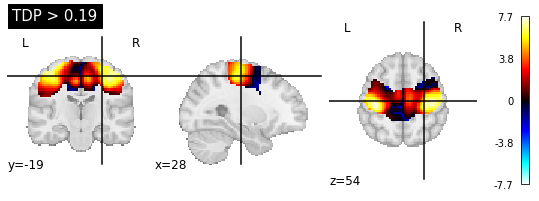

In [28]:
from nilearn.plotting import plot_stat_map
plot_stat_map(cluster_map, title='TDP > %s' % ("{0:.2f}".format(notip_bound)))

### Using Notip on user-defined clusters

In [21]:
import numpy as np
from scipy import ndimage
from nilearn._utils.niimg import _safe_get_data

stat_threshold = 3.5

# Defining "faces" connectivity for voxels

conn_mat = np.zeros((3, 3, 3), int)
conn_mat[1, 1, :] = 1
conn_mat[1, :, 1] = 1
conn_mat[:, 1, 1] = 1

stat_map = _safe_get_data(z_map, ensure_finite=True)

# Thresholding the map
binarized = stat_map > stat_threshold
binarized = binarized.astype(int)

# Extracting clusters from thresholded map
label_map = ndimage.measurements.label(binarized, conn_mat)[0]

cluster_mask = label_map == 1 # First cluster

In [19]:
cluster_mask.shape

(53, 63, 46)

In [22]:
np.count_nonzero(cluster_mask)

796

This cluster comprises 796 voxels.

In [23]:
from notip.posthoc_fmri import get_tdp_bound_notip
notip_bound, cluster_map = get_tdp_bound_notip(z_map, fmri_input, cluster_mask)

Let's visualize the results:

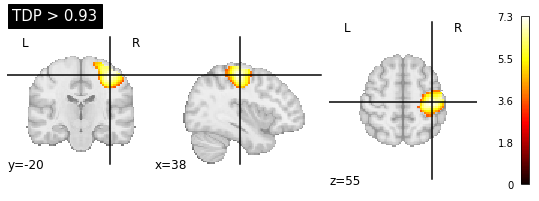

In [24]:
from nilearn.plotting import plot_stat_map
plot_stat_map(cluster_map, title='TDP > %s' % ("{0:.2f}".format(notip_bound)))

# References

Blain, Alexandre, Bertrand Thirion, and Pierre Neuvial. "Notip: Non-parametric True Discovery Proportion control for brain imaging." NeuroImage 260 (2022): 119492. doi:https://doi.org/10.1016/j.neuroimage.2022.119492

Dimitri Papadopoulos Orfanos, Vincent Michel, Yannick Schwartz, Philippe Pinel, Antonio Moreno, Denis Le Bihan, and Vincent Frouin. The brainomics/localizer database. NeuroImage, 144:309–314, 2017. Data Sharing Part II. URL: https://www.sciencedirect.com/science/article/pii/S1053811915008745, doi:https://doi.org/10.1016/j.neuroimage.2015.09.052.